In [ ]:
## Vaishu Myadam (vmyadam1208@gmail.com)
## June, 2020

## Using Kaggle's 1.6 million tweets dataset and various online tutorials (including snippets from StackOverflow)

In [ ]:
%tensorflow_version 2.x # This line is necessary because I'm using a notebook

In [ ]:
# Necessary imports:

import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.preprocessing.text import Tokenizer
import gensim
import re
import time
import numpy as np
import os
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from collections import Counter
import itertools

In [ ]:
# Defining constants

W2V_SIZE = 300
SEQUENCE_LENGTH = 300

In [ ]:
# Reading in data

# Using google colab's google drive mounting option:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/input.csv', encoding ="ISO-8859-1" , names=["target", "ids", "date", "flag", "user", "text"])
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
# Data preprocessing

Text(0.5, 1.0, 'Dataset labels distribuition')

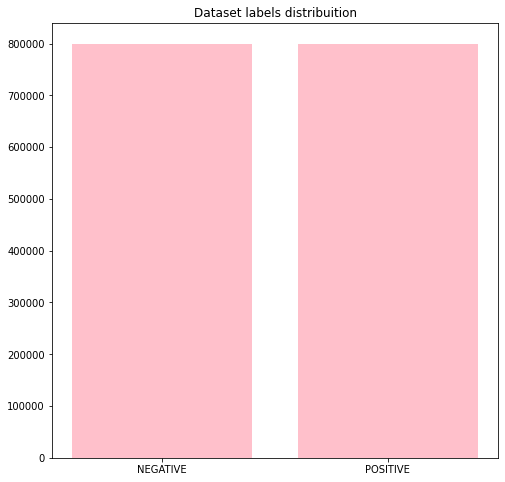

In [ ]:
int_to_sentiment_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def map_sentiments(label):
    return int_to_sentiment_map[int(float(label))]
df.target = df.target.apply(lambda x: map_sentiments(x))   

target_cnt = Counter(df.target)
plt.figure(figsize=(8,8))
plt.bar(target_cnt.keys(), target_cnt.values(), width = 0.8, color = 'pink')
plt.title("Dataset labels distribuition")

In [ ]:
nltk.download('stopwords')
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

def preprocess(text, stem=False):
    text = re.sub("@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+", ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return ' '.join(tokens)

In [ ]:
# Building models

In [ ]:
df.text = df.text.apply(lambda x: preprocess(x))
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

documents = [_text.split() for _text in df_train.text] 
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, window=7, min_count=10, workers=8)
w2v_model.build_vocab(documents)
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)


In [ ]:
w2v_model.train(documents, total_examples=len(documents), epochs=32)

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)
vocab_size = len(tokenizer.word_index) + 1
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

In [ ]:
labels = df_train.target.unique().tolist()
labels.append('NEUTRAL')
labels
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [ ]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)


In [ ]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          87125700  
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 87,286,201
Trainable params: 160,501
Non-trainable params: 87,125,700
_________________________________________________________________


In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer="adam", # Can replace with any other optimizer 
              metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train,
                    batch_size=1024,
                    epochs = 8, # Took too long with higher epochs
                    validation_split = 0.1,
                    verbose = 1,
                    callbacks=[ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)])

Train on 1152000 samples, validate on 128000 samples
Epoch 1/8
1152000/1152000 [==============================] - 865s 751us/step - loss: 0.5103 - accuracy: 0.7460 - val_loss: 0.4651 - val_accuracy: 0.7781
Epoch 2/8


/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


1152000/1152000 [==============================] - 860s 747us/step - loss: 0.4851 - accuracy: 0.7634 - val_loss: 0.4585 - val_accuracy: 0.7824
Epoch 3/8
1152000/1152000 [==============================] - 838s 728us/step - loss: 0.4773 - accuracy: 0.7682 - val_loss: 0.4541 - val_accuracy: 0.7849
Epoch 4/8
1152000/1152000 [==============================] - 845s 733us/step - loss: 0.4736 - accuracy: 0.7710 - val_loss: 0.4537 - val_accuracy: 0.7857
Epoch 5/8
1152000/1152000 [==============================] - 848s 736us/step - loss: 0.4708 - accuracy: 0.7727 - val_loss: 0.4496 - val_accuracy: 0.7882
Epoch 6/8
1152000/1152000 [==============================] - 846s 734us/step - loss: 0.4689 - accuracy: 0.7735 - val_loss: 0.4483 - val_accuracy: 0.7880
Epoch 7/8
1152000/1152000 [==============================] - 848s 736us/step - loss: 0.4671 - accuracy: 0.7746 - val_loss: 0.4476 - val_accuracy: 0.7900
Epoch 8/8
1152000/1152000 [==============================] - 847s 736us/step - loss: 0.4657 

In [ ]:
# Presenting results

In [ ]:
score = model.evaluate(x_test, y_test, batch_size=1024)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

320000/320000 [==============================] - 22s 68us/step

ACCURACY: 0.7899937629699707
LOSS: 0.44590294375419615


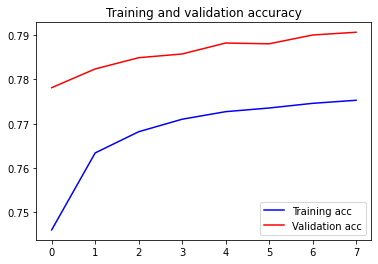

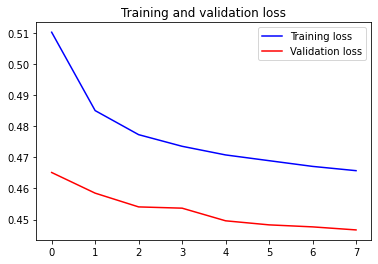

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend() 

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [ ]:
def label_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = 'NEUTRAL'
        if score <= 0.4:
            label = 'NEGATIVE'
        elif score >= 0.7:
            label = 'POSITIVE'
        return label
    else:
        return 'NEGATIVE' if score < 0.5 else 'POSITIVE'

In [ ]:
def predict(text, include_neutral=True):
    start_at = time.time()
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    score = model.predict([x_test])[0]
    
    label = label_sentiment(score, include_neutral=include_neutral)
    return {"label": label, "score": float(score), "elapsed_time": time.time()-start_at}  

In [ ]:
predict("I hate the weather")

{'elapsed_time': 0.23172664642333984,
 'label': 'NEGATIVE',
 'score': 0.005270485766232014}

In [ ]:
y_prediction = []
y_test = list(df_test.target)

scores = model.predict(x_test, verbose=1, batch_size=8000)
y_prediction = [label_sentiment(score, include_neutral=False) for score in scores]

320000/320000 [==============================] - 14s 45us/step


In [ ]:
print(classification_report(y_test, y_prediction))



              precision    recall  f1-score   support

    NEGATIVE       0.78      0.80      0.79    159494
    POSITIVE       0.80      0.78      0.79    160506

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



In [ ]:
accuracy_score(y_test, y_prediction)

0.78999375